# エピポーラ幾何

## 目的

このチュートリアルでは

* 多視点幾何の基礎を学ぶ．
* エピポール(epopole)，エピポーラ線(epopolar line)，エピポーラ拘束(epipolar constraint)などについて学ぶ．


## 基本概念

ピンホール・カメラを使って撮影した画像は重要な情報(画素の距離情報)を失っている．3次元空間を2次元画像に写像したことにより、画素に対応する対象点とカメラとの距離が分からなくなってしまうとも言える．そのため，ピンホール・カメラを使って距離情報を計算できるのか、というのは重要な疑問である．この問い対する答えは，「複数台のカメラを使えば可能」というものである．2台のカメラを使うことをステレオ視(stereo vision)と呼ぶが，実は私たち人間の目の働きと同じように動作する．早速OpenCVが提供する技術を見ていくことにしよう．

(この分野に関しては，Gary Bradskiらが書いた Learning OpenCV に多くの情報が載っている．)

距離画像を扱う前に多視点幾何の基本概念を理解しよう．ここではエピポーラ幾何を扱う．下の画像は，あるシーンを2台のカメラで撮影した状況を描いている．OとO'はそれぞれのカメラの投影中心とし、３次元空間上の点Xが２つのカメラの投影面にそれぞれ投影されているとする。

![](http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/_images/epipolar.jpg)

もし左のカメラだけを使うのであれば，我々には左のカメラの画像上の点 $x$ に対し、それが3次元空間上のどの点に対応するか、その位置は一般には分からない．なぜならカメラの投影中心$O$と点 $x$ を結ぶ直線 $OX$ 上の点であればみな左の画像においては点 $x$ に写像されるからである．しかし，右のカメラで撮影した画像では，直線 $OX$ 上の点はそれぞれ異なる点に写像される。このことから，2枚の画像があれば3次元点を正しく三角測量できることが分かる．これが多視点幾何における3次元計測の基本である．

直線 $OX$ 上の点は、右側カメラの画像平面上では直線を形成する(これを直線 $l'$ とする)．この直線のことを点 $x$ の「エピポーラ線(epiline)」と呼ぶ．$OX$ 上の点 $x$ を右側の画像で探すには，このエピポーラ線上を探索すればよい（つまり、$x$に対する右側画像の対応点を探すには画像全体ではなくこのエピポーラ線上だけを探索すればよいので、処理速度と精度の向上につながる．）このことを ***エピポーラk拘束(Epipolar Constraint)*** と呼ぶ．同様に，一方の画像の点はみな、他方の画像において対応するエピポーラ線をもつことになる．なお、３次元空間上の点 X とカメラの投影中心 $O$ ， $O'$ が作る平面 $XOO'$ のことを ***エピポーラ面(Epipolar Plane)*** と呼ぶ．

上記の設定から，右側のカメラの投影中心 $O'$ を左側画像へ写像したものが $e$ となることがわかる．この点を ***エピポール(epipole)*** と呼ぶ．エピポールはカメラの投影中心を結ぶ直線と画像平面との交点である．同様に $e'$ は左側カメラに対応するエピポールである．場合によって(カメラの位置関係によって)エピポールを画像で特定できない(写っていない)こともあるが，その場合はエピポールは画像の外に位置しているものとする。

全てのエピポーラ線はエピポールを通過する．つまりエピポールの位置を見つけるためには複数のエピポーラ線を探し，それらの交点を見つければよいことになる．

ここではエピポーラ線とエピポールの検出を取り扱う。これらの検出には ***基礎行列(Fundamental Matrix ) ($F$)*** と ***基本行列(Essential Matrix) ($E$) ***の二つの要素が必要になる．基本行列は左側カメラに対する右側カメラの相対的な位置・姿勢の情報を含んでいる．以下の画像を見てみよう(画像は以下から転載: Learning OpenCV by Gary Bradsky):

![](http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/_images/essential_matrix.jpg)

しかし，できれば画面の座標だけを使った計算が好ましいだろう。基本行列$E$は２つのカメラを３次元の実空間上で関連付ける、平行移動(Translation)と回転(Rotation)の情報を含む。基礎行列$F$は$E$がもつ情報に加え、2つのカメラの内部パラメータの情報も含むものである。そのためFにより２つのカメラの関係を画素単位で関連付けることができる．(もしも平行化した画像があり、点の座標を焦点距離で割って正規化すれば， $F=E$ が成り立つ)．簡単に言うと，基礎行列$F$は一方の画像の点をもう一方の画像の線(エピポーラ線)に写像する．この計算には両方の画像の対応点が必要で、少なくとも8組の対応点が必要になる(8点アルゴリズムを使えば)。しかし，対応点はあればあるほどよく、RANSACを用いて頑健な結果が得られる．

## 実装(コード)

基礎行列を計算するには、2枚の画像においてできるだけ多くの対応点の組み合わせを見つける必要がある．ここではSIFT特徴量とBFMatcherに基づくマッチングを使って対応点ペアの検出を行う．(使用する画像: [left.jpg](http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/py_tutorials/py_calib3d/py_epipolar_geometry/left.jpg), [right.jpg](http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/py_tutorials/py_calib3d/py_epipolar_geometry/right.jpg))

In [47]:
%matplotlib inline
import cv2
import numpy as np
from matplotlib import pyplot as plt

img1 = cv2.imread('left.jpg',0)  #queryimage # left image
img2 = cv2.imread('right.jpg',0) #trainimage # right image

# Instead SIFT+FLANN, we use SIFT+BFMatch

img1 = cv2.imread('left.jpg',0)  # left
img2 = cv2.imread('right.jpg',0) # right

sift = cv2.xfeatures2d.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

# Brute-Force Matcher
bf = cv2.BFMatcher()

# 
matches = bf.knnMatch(des1, des2, k=2)

# 
ratio = 0.65
good = []
pts1 = []
pts2 = []
for i, (m, n) in enumerate(matches):
    if m.distance < ratio * n.distance:
        good.append([m])
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)


この段階で両画像から取得した対応点対のリストを保持している．次に，これらの対応点群から [cv2.findFundamentalMat](http://docs.opencv.org/3.0-beta/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html?highlight=cv2.findfundamental#cv2.findFundamentalMat) 関数を使って基礎行列を計算する．ここでは第3引数に `cv2.FM_LMEDS` を指定し，ロバスト推定を行っている．

In [48]:
pts1 = np.float32(pts1)
pts2 = np.float32(pts2)

# compute F
F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_LMEDS) #cv2.FM_RANSAC

# We select only inlier points
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]


次にエピポーラ線を計算する．1枚目の画像上の点に対応するエピポーラ線は2枚目の画像上に表示される．ここでは正しい画像を選ぶ必要がある．複数のエピポーラ線を配列として保持しているので，これらの画像上にエピポーラ線を描画する関数を作成する．

In [49]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - img2上の点に対応するエピポーラ線を描画する画像
        lines - 対応するエピポーラ線 '''
    r,c = img1.shape
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv2.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

これで２つの画像上にエピポーラ線を描けるようになる．

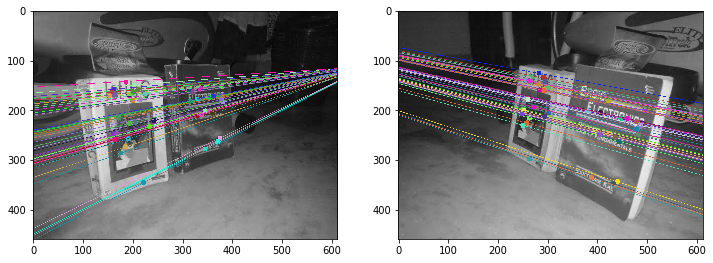

In [50]:
# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(img1,img2,lines1,pts1,pts2)

# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img2,img1,lines2,pts2,pts1)

plt.figure(figsize=(12,5))
plt.subplot(121),plt.imshow(img5)
plt.subplot(122),plt.imshow(img3)
plt.show()

In [51]:
len(matches)

815

左画像中の全てのエピポーラ線が画像の外側(右)の一点で交差している事が分かる．この交点がエピポールである．

より良い結果を得るためには解像度の良い画像を撮影したり，3次元的に分布している対応点を使って基礎行列を計算する必要がある．

## 補足資料

SIFTの代わりにORBを使った例。どういうわけかエピポーラ線が異なる。

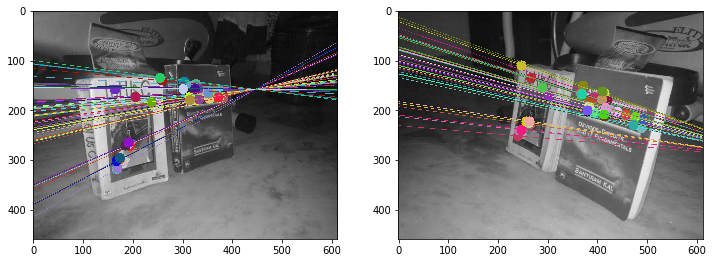

In [55]:
# ORB+Brute Force
import cv2
import numpy as np
from matplotlib import pyplot as plt


def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        cv2.line(img1, (x0,y0), (x1,y1), color,1)
        cv2.circle(img1,tuple(pt1),10,color,-1)
        cv2.circle(img2,tuple(pt2),10,color,-1)

    return img1,img2

img1 = cv2.imread('left.jpg',0)  #queryimage # left image
img2 = cv2.imread('right.jpg',0) #trainimage # right image

orb = cv2.ORB_create()

# find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)

# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors.
matches = bf.match(des1,des2)

good = []
pts1 = []
pts2 = []

D_MATCH_THRES = 65.0
for m in matches:
    if m.distance < D_MATCH_THRES:
        good.append(m)
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)

pts1 = np.float32(pts1)
pts2 = np.float32(pts2)

# compute F
F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_RANSAC) #cv2.FM_LMEDS

# We select only inlier points
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(img1,img2,lines1,pts1,pts2)

# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img2,img1,lines2,pts2,pts1)

plt.figure(figsize=(12,5))
plt.subplot(121),plt.imshow(img5)
plt.subplot(122),plt.imshow(img3)
plt.show()

Bradski, G. & Kaehler, A. (2008). Learning OpenCV. O'Reilly.(松田訳, 「詳解OpenCV」. O'Reilly Japan. 2009) : OpenCV 1の本であることに注意(ググると原著のPDFが見つかることがある)--- Learning OpenCV3が2016年12月に出版された

## 課題

1. 重要なトピックの一つとしてカメラの前進運動が挙げられる．前進運動をするカメラによって撮影された2枚の画像のエピポールは，エピポーラ線が一点で交差するため同じ位置に観測される．詳しくは [この資料](http://answers.opencv.org/question/17912/location-of-epipole/) を参照せよ．
2. 基礎行列の推定はマッチングの精度(外れ値など)に対して敏感である．全対応点が同一平面上に乗っている時，精度が悪くなってしまう．詳しくは [この資料](http://answers.opencv.org/question/18125/epilines-not-correct/) を参照せよ．